[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/16_VAE.ipynb)

# Let's Make a Variational AutoEncoder (VAE)

--Scott H. Hawley

*Jan 30, 2024: This is a Work In Progress!*

---

## The basic ideas:
* we force the Decoder to decode points in latent space *nearby* to the point corresponding to the encoded image
* we 'scrunch' the latent space so it looks like a gaussian

## Setup Imports

In [298]:
# we'll use pytorch lightning as an alternative to raw pytorch
!pip install -qq lightning

In [299]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import lightning as L
import torch.nn.functional as F

## Setup Dataset

Yep, good 'ol MNIST. It's small and easy and you can do it on a CPU. Let's keep everything super-simple at first: black & white images.

In [300]:
train_ds = MNIST(root='./data', train=True,  download=True, transform=ToTensor())
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")

Data set lengths: train: 60000, test: 10000


Inspect it a bit..

y (target) = 5 
x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0


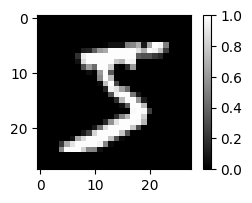

In [4]:
x, y = train_ds[0]   # pick an element
print(f"y (target) = {y} ")

def show_xs(xs, show_stats=True):
    "A little utility we'll call again & again to show one or more images"
    if type(xs) is not list: xs = list(xs)
    ncols = len(xs)
    fig, axs = plt.subplots(figsize=(3*ncols,2), ncols=ncols, squeeze=False)
    ax = axs.ravel()
    for col, x in enumerate(xs):
        if len(x.shape)>2: x = x[0] # remove any batch dimension
        if show_stats:
            if ncols > 1: print(f"col {col}: ",end="")
            print(f"x.shape = {tuple(x.shape)}, min(x) = {torch.min(x)}, max(x) = {torch.max(x)}")
        digit = ax[col].imshow(x.detach().cpu().numpy(), cmap='gray')
        fig.colorbar(digit, ax=ax[col])
    plt.show()

show_xs([x])

Define dataloaders

In [5]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=4, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Make an (Regular) AE Model


First we'll try a regular autoencoder. Then we'll make it "variational"

In [6]:
latent_dim = 3   # more = better reconstructions, but 3 we can plot!

n_hid = [256, 64]  # could imagine adding more layers

act = nn.LeakyReLU # works ok.

encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], latent_dim))

decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                #nn.Sigmoid(),        # optional. we do want outputs on [0,1]
                )

z =  tensor([[ 0.0778, -0.0028,  0.0533]], grad_fn=<AddmmBackward0>)
x.shape = (28, 28), min(x) = -0.2171027809381485, max(x) = 0.2286178171634674


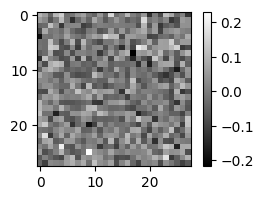

In [7]:
# test it, just to make sure we get no errors from mmult ops
z = encoder(x.view(x.size(0), -1) )
print("z = ",z)
x_hat = decoder(z)
x_hat = x_hat.view(x.size(0), 28, -1)
show_xs(x_hat)

^^ That was with randomly initialized weights, so we expect a random image. This was just to test that the matrix multiplications work out right.

In [8]:
# instead of nn.Module, we use L.LightningModule
class AEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        z, x_hat = self.forward(x)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log('loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [9]:
autoencoder = AEModel(encoder, decoder)

epochs = 4
trainer = L.Trainer(max_epochs=epochs, devices="auto")
trainer.fit(model=autoencoder, train_dataloaders=train_dl)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 217 K 
1 | decoder | Sequential | 218 K 
---------------------------------------
435 K     Trainable params
0         Non-trainable params
435 K     Total params
1.744     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


z =  tensor([[ 0.0778, -0.0028,  0.0533]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = -0.11879678070545197, max(x) = 0.9959452748298645


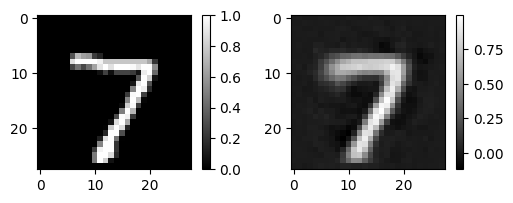

In [10]:
@torch.no_grad()
def test_inference(model, idx=None):
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    x_hat = model.forward(x.view(x.size(0), -1))[-1]
    print("z = ",z)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x,x_hat])

idx = 0
test_inference(autoencoder, idx=idx)

## Now Let's Make it 'Varational'

In [11]:
# encoder now spits out mean and variance
vae_encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], latent_dim*2)) # *2 b/c mu, log_var

# decoder same as before
decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                #nn.Sigmoid(), # optional forcing to [0,1]
                )

In [12]:
# instead of nn.Module, we use L.LightningModule
class VAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x):
        z = self.encoder(x)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat)
        return z, mu, log_var, z_hat, x_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        z, mu, log_var, z_hat, x_hat = self.forward(x)
        recon_loss = nn.functional.mse_loss(x_hat, x)
        scrunch_factor = 0.01     # li'l dab'll do ya on the kl scrunching
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * scrunch_factor)
        self.log('loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [13]:
vae = VAEModel(vae_encoder, decoder)

epochs = epochs*2
trainer = L.Trainer(max_epochs=epochs, devices="auto")
trainer.fit(model=vae, train_dataloaders=train_dl)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 217 K 
1 | decoder | Sequential | 218 K 
---------------------------------------
436 K     Trainable params
0         Non-trainable params
436 K     Total params
1.745     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=8` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


z =  tensor([[ 0.0778, -0.0028,  0.0533]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = -0.042473144829273224, max(x) = 0.9122146368026733


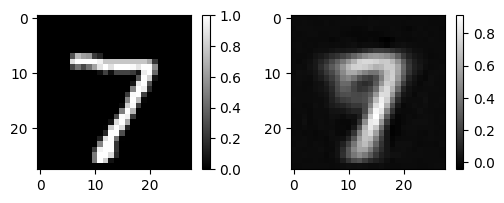

In [14]:
test_inference(vae, idx=idx)

Looks similar to the regular autoencoder, right?

Now let's try perturbing our input a bit

## Comparing the AE and VAE

Perturbing the regular autoencoder with strength = 30.0:


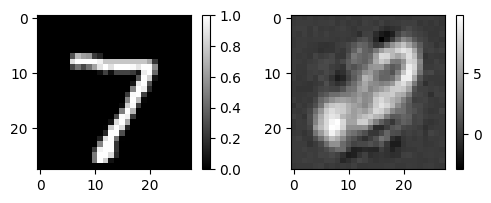

Perturbing the VAE with strength = 30.0:


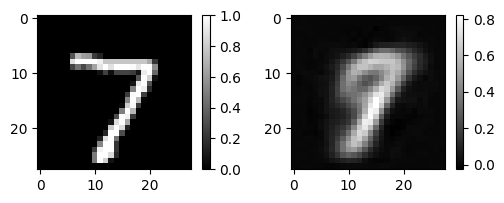

In [15]:
@torch.no_grad()
def infer_perturb(model, idx=None, strength=1.0):
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    z = model.encoder(x.view(x.size(0), -1))
    if z.shape[-1] > latent_dim: z = z[:,:latent_dim] # if VAE, just use the mean values
    z_hat = z + strength*torch.randn_like(z)
    x_hat = model.decoder(z_hat)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x,x_hat], show_stats=False)

idx=0
strength = 30.0
print(f"Perturbing the regular autoencoder with strength = {strength}:")
infer_perturb(autoencoder, idx=idx, strength=strength)
print(f"Perturbing the VAE with strength = {strength}:")
infer_perturb(vae, idx=idx, strength=1.0)

Depending on the random values you get, perturbations may cause the regular AE output to look like not-a-number, whereas the VAE output is probably more stable.

Note that without any final rescaling of outputs (e.g. via `nn.Sigmoid`), typically the output of the regular AE extends wayyy outside the [0,1] intensity bounds whereas the VAE's outputs are still properly bounded.


## Further Comparisons: Add interpolation, 3D viz, more.

TODO


## Part 2: Adding Controls (Conditional Generation)


"Conditioning" means attaching controls to the model that, via training, it can learn to associate with specific kinds outputs. For example, we could do "class conditioning" where we tell it what class --- in our case, which digit -- we want the output to be.

The conditioning may take the form of adding or multiplying numbers to the activations, concatenating some controls,...lots of things. One general class of conditioning methods is often referred to as [FiLM layers](https://distill.pub/2018/feature-wise-transformations/), where FiLM stands for **F**eature-w**i**se **L**inear **M**odulation. Essentially it means we will apply our conditioning by both addition and multiplication.

How and where we apply the conditioning is up to us: we could apply it to the encoder, the latent space, and/or the decoder. We could include the conditioning signal in only one spot, or in between all layers. ...It kind of depends on what we want to do.  

Often for "Generative AI" systems, we leave the Encoder side alone, and apply the conditioning to the latent variable and the Decoder side. (Note also that any layer activation can be thought of a "latent variable", and some models don't necessarily restrict their attention to the "center of the hourglass" when it comes to talking about latents.)

> TODO: Draw a diagram!

Let's try a few different conditioning methods to see what we like best.


In [301]:
# Here's one way to make a FiLM layer
class FiLM(nn.Module):
    def __init__(self, x_dim, cond_dim):
        super().__init__()
        self.gamma_gen = nn.Linear(cond_dim, x_dim)
        self.beta_gen  = nn.Linear(cond_dim, x_dim)

    def forward(self, x, cond):
        gamma = self.gamma_gen(cond)
        beta  = self.beta_gen(cond)
        return x * gamma + beta

We could do a conditional "regular autoencoder" but it would be kind of boring because whichever digit you ask for, say a 7, it'll just produce the exact same 7 every time.  We want some *variation* to the outputs, so let's make a conditional VAE

**"conditioning strength":**
Maybe this is just me, but I like the idea of having a "conditioning strength" parameter, so that we can tell the model whether we want no conditioning or full conditioning, or somewhere in between.

I haven't seen this done elsewhere...but I just like the idea, so here goes!

In [326]:
# Conditional VAE

latent_dim = 4  # give it a bit more space to operate in

n_hid = [256, 64]  # could imagine adding more layers

act = nn.GELU # this is popular in many models

# should we condition the encoder too?
vae_encoder = nn.Sequential(    # same as before
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], 2*latent_dim))

cond_dim = 10  # we'll use one-hot encoding for class conditioning; 10 classes


# Let's try sticking a FiLM before each Linear layer in the Decoder.
# Oh, for the decoder we can't just use nn.Sequential anymore...
class DecoderCond(nn.Module):
    def __init__(self, latent_dim, n_hid, cond_dim):
        super().__init__()
        self.f1 = FiLM(latent_dim, cond_dim)
        self.l1 = nn.Linear(latent_dim, n_hid[1])
        self.f2 = FiLM(n_hid[1], cond_dim)
        self.l2 = nn.Linear(n_hid[1], n_hid[0])
        self.f3 = FiLM(n_hid[0], cond_dim)
        self.l3 = nn.Linear(n_hid[0], 28 * 28)
        self.act = act()
        # could add optional sigmoid here

    def forward(self, x, cond):
        x = self.f1(x, cond)
        x = self.act( self.l1(x) )
        x = self.f2(x, cond)
        x = self.act( self.l2( x ) )
        x = self.f3(x, cond)
        x = self.l3( x )
        return x

vae_decoder_cond = DecoderCond(latent_dim, n_hid, cond_dim)


In [327]:
# instead of nn.Module, we use L.LightningModule
class CondVAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = vae_encoder
        self.decoder = vae_decoder_cond
        self.ema_loss = 0.06

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x, cond):
        z = self.encoder(x)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat, cond)
        return z, mu, log_var, z_hat, x_hat

    def gen(self, y, n_gen=1):
        mu = 4*torch.randn((n_gen, latent_dim))
        log_var = 2*torch.randn((n_gen, latent_dim))
        z_hat = self.reparam_sample(mu, log_var)
        cond = F.one_hot(torch.tensor(y), num_classes=10).float()
        x_hat = self.decoder(z_hat, cond)
        return x_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        cond = F.one_hot(y, num_classes=10).float().to(x.device) # pass in the desired output class as cond

        if torch.rand((1)) < 0.2: # sometimes, just regular vae
            cond_strength, x_targ, cond_targ = 0.0, x, cond  # just run it as an ordinary autoencoder, no-op conditioning
        else:
            cond_strength = torch.rand((1)).to(x.device)
            # draw x2, y2 values from elsewhere in the batch
            rand_inds = torch.randperm(x.size()[0])
            x2, y2 = x[rand_inds], y[rand_inds]
            x2 = x2.view(x.size(0), -1)
            cond2 = F.one_hot(y2, num_classes=10).float().to(x.device)
            # target is between x and x2, determined by cond_strength
            x_targ    = torch.lerp(x,    x2,    cond_strength)
            cond_targ = torch.lerp(cond, cond2, cond_strength)

        z, mu, log_var, z_hat, x_hat = self.forward(x, cond_targ)

        recon_loss = nn.functional.mse_loss(x_hat, x_targ)
        scrunch_factor = 0.1
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * scrunch_factor)
        with torch.no_grad():
            self.ema_loss = 0.99*self.ema_loss + 0.01*loss.detach().item()
            self.log('ema_loss', self.ema_loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [328]:
cond_vae = CondVAEModel(encoder, decoder)

epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto")
trainer.fit(model=cond_vae, train_dataloaders=train_dl)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type        | Params
----------------------------------------
0 | encoder | Sequential  | 217 K 
1 | decoder | DecoderCond | 225 K 
----------------------------------------
443 K     Trainable params
0         Non-trainable params
443 K     Total params
1.774     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summar

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


hmm... the loss didn't seem to go down. not good. TBD.

Let's take a look at inference:

       Source,                Destination,              Expected,                Output
y_targ =  2
cond_targ = tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
z =  tensor([[ 0.0778, -0.0028,  0.0533]], grad_fn=<AddmmBackward0>)


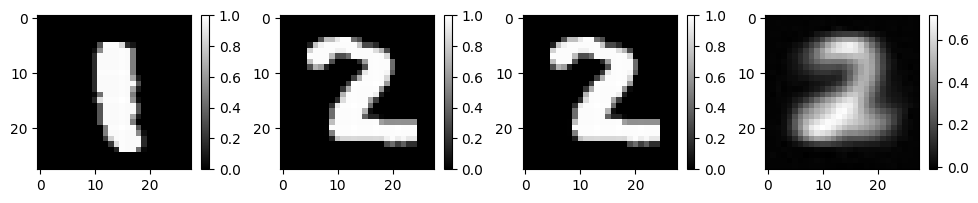

In [339]:
@torch.no_grad()
def test_cond_inference(model, cond_strength=1.0, idx=None):
    "Try to map from one digit to another digit"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    x2, y2 = test_ds[idx+1]
    x_targ = torch.lerp(x, x2, cond_strength) # picture of what we might expect
    y_targ = y2
    print("y_targ = ",y_targ)
    cond = F.one_hot(torch.tensor(y), num_classes=10).float()  # but now we go all the way
    cond2 = F.one_hot(torch.tensor(y2), num_classes=10).float()
    cond_targ = torch.lerp( cond, cond2, cond_strength)
    print("cond_targ =",cond_targ)
    x_hat = model.forward(x.view(x.size(0), -1), cond_targ)[-1]
    print("z = ",z)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x,x2,x_targ,x_hat], show_stats=False)


idx = torch.randint( len(test_ds)-1, (1,))[0]
print("       Source,                Destination,              Expected,                Output")
test_cond_inference(cond_vae, cond_strength=1.0, idx=idx )


x.shape = (28, 28), min(x) = -0.009187683463096619, max(x) = 0.7141402363777161


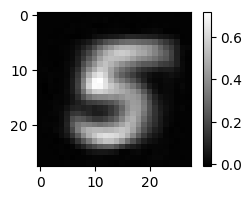

x.shape = (28, 28), min(x) = -0.00827208161354065, max(x) = 0.7132763266563416


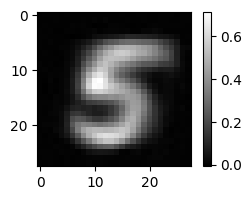

x.shape = (28, 28), min(x) = -0.00876644253730774, max(x) = 0.7138411402702332


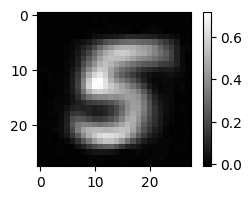

In [336]:
@torch.no_grad()
def test_cond_gen(model, y_targ, idx=None):
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x_hat = model.gen(y_targ)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x_hat])

y_targ=5
test_cond_gen(cond_vae, y_targ, idx=idx)
test_cond_gen(cond_vae, y_targ, idx=idx)
test_cond_gen(cond_vae, y_targ, idx=idx)

hmmm... not a lot of variety

## Going Further: VQ-VAE

"Vector Quantization"